# 📰 FNSPID News Data Analysis

This notebook **derives key metrics** and **creates visualizations** based on the **FNSPID news dataset**.  
It aims to provide clear insights into the data’s structure, trends, and underlying patterns.

In [1]:
import polars as pl
import re
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt
import hvplot.polars
from ipywidgets import IntSlider

# autoreload
%load_ext autoreload
%autoreload 2

In [15]:
from src.CRSP_ITI_FNSPID_merge import process_crsp_iti_fnspid_dataset
df = process_crsp_iti_fnspid_dataset()

[INFO] Final dataset already exists at /Users/matthiaswyss/Documents/EPFL/2025-26/MA3/COM-412 Research project/news-based-asset-pricing/data/merged/crsp_iti_fnspid.csv. Loading from disk...


## Headline Distribution Analysis 

How is the FNSPID dataset distributed ? 

In [17]:
percentage = df['Article_title'].is_not_null().sum() / df.shape[0] * 100
print(f"Percentage of timestamps with articles: {percentage:.2f}%")

Percentage of timestamps with articles: 15.11%


In [18]:
df = df.with_columns([
    pl.col("date").dt.year().alias("year")
])

yearly_counts = df.group_by('year').agg(pl.col('Article_title').is_not_null().sum().alias('count_with_headlines')).sort('year')

In [19]:
yearly_counts.hvplot.bar(
    x="year",
    y="count_with_headlines",
    title="Yearly Headline Counts",
    xlabel="Year",
    ylabel="Number of Headlines",
    width=700,
    height=400,
    legend="top_right"
)

:Bars   [year]   (count_with_headlines)

In [20]:
def process_text(articles, extra_stopwords=None):

    text = ' '.join(articles.to_series())

    text = re.sub(r'[^A-Za-z\s]', '', text)

    text = text.lower()

    stopwords = set(STOPWORDS).union(extra_stopwords) if extra_stopwords else set(STOPWORDS)
    text = ' '.join(word for word in text.split() if word not in stopwords)

    return text

Text(0.5, 1.0, 'Company News Word Cloud')

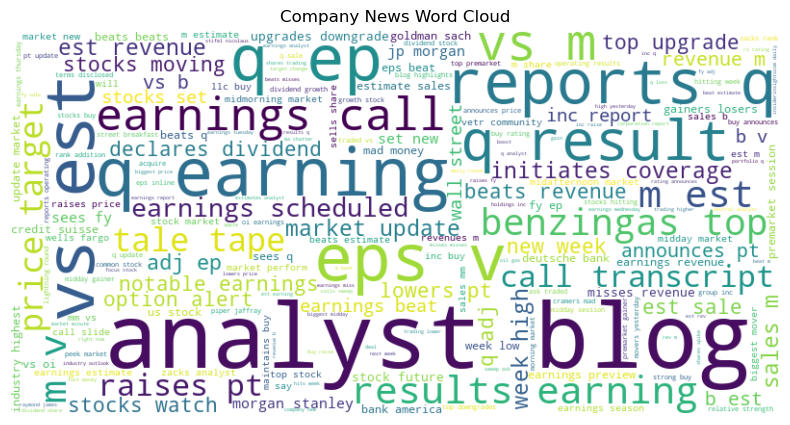

In [21]:
articles = df.select(pl.col("Article_title")).drop_nulls()
text_processed = process_text(articles)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_processed)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Company News Word Cloud")

## FINBERT Embedding Behaviour on Headlines

We examine how **FINBERT embeddings** structure our headline space

In [22]:
df = df.with_columns([
    (pl.col('Positive') - pl.col('Negative')).alias('sentiment_score')
]).unique()

In [23]:
df = df.with_columns([
    df['date'].dt.year().alias('year')
])

In [24]:
df.group_by('year').agg(pl.col('sentiment_score').mean()).sort('year').hvplot.line(
    x="year",
    y="sentiment_score",
    title="Average Yearly Sentiment Score",
    xlabel="Year",
    ylabel="Average Sentiment Score",
    width=700,
    height=400,
    legend="top_right"
)

:Curve   [year]   (sentiment_score)

## Headline Distribution Analysis - Constellation Brands

In this section, we explore how the **distribution of news headlines** related to *Constellation Brands* differs between **ITI** and **non-ITI** articles.


In [25]:
import polars as pl

# --- Parameters ---
permno_id   = 16678
high_thr    = 0.8   
low_thr     = 0.1   
window_days = 10    


company = (
    df
    .filter((pl.col("permno") == permno_id))
    .select(["date", "Article_title", "ITI(13D)"])
    .with_columns(
        pl.col("date").dt.date().alias("date")  
    )
)

iti_events = (
    company
    .filter(pl.col("ITI(13D)") > high_thr)
    .select(pl.col("date").alias("event_date"))
    .unique()
)

non_iti_events = (
    company
    .filter(pl.col("ITI(13D)") < low_thr)
    .select(pl.col("date").alias("event_date"))
    .unique()
)


def build_window_calendar(events: pl.DataFrame, days: int) -> pl.DataFrame:
    return (
        events
        .with_columns([
            (pl.col("event_date") - pl.duration(days=days)).alias("start"),
            (pl.col("event_date")).alias("end"),
        ])
        .with_columns(
            pl.date_ranges(pl.col("start"), pl.col("end"), interval="1d").alias("window_dates")
        )
        .select(pl.col("window_dates"))
        .explode("window_dates")
        .select(pl.col("window_dates").alias("date"))
        .unique()  
    )

calendar_iti     = build_window_calendar(iti_events, window_days)
calendar_non_iti = build_window_calendar(non_iti_events, window_days)


articles_in_iti_window = (
    company.join(calendar_iti, on="date", how="inner")
           .unique(subset=["date", "Article_title"])   # use article_id if available
           .sort("date")
)

articles_in_non_iti_window_all = (
    company.join(calendar_non_iti, on="date", how="inner")
           .unique(subset=["date", "Article_title"])
           .sort("date")
)

articles_in_non_iti_window = (
    articles_in_non_iti_window_all.join(
        articles_in_iti_window.select("date", "Article_title"),
        on=["date", "Article_title"],
        how="anti"
    )
)

iti_titles     = articles_in_iti_window.select("Article_title").drop_nulls()
non_iti_titles = articles_in_non_iti_window.select("Article_title").drop_nulls()

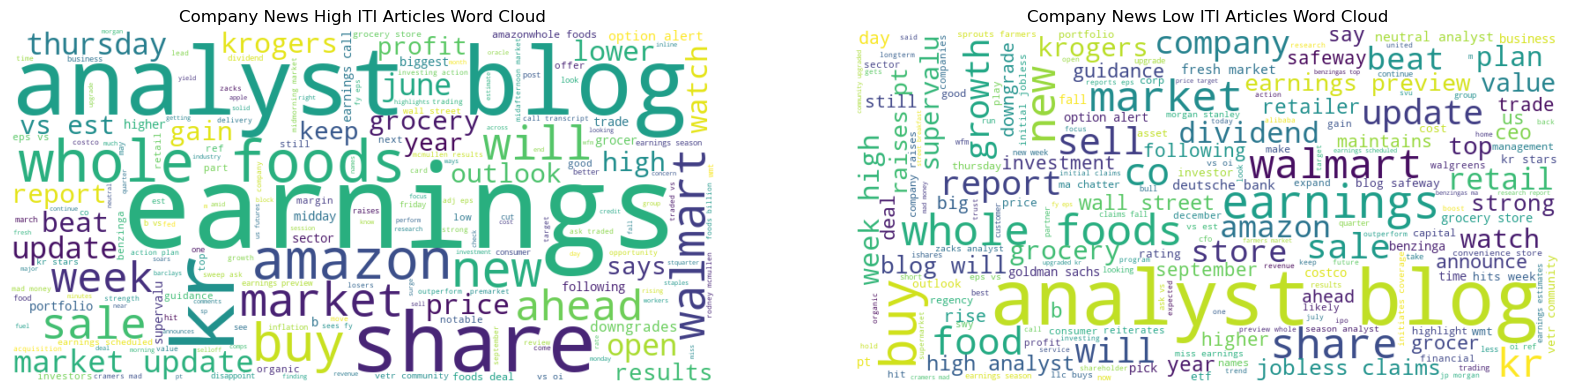

In [26]:
text_iti = process_text(iti_titles, extra_stopwords={"kroger", "brands", "stock", "stocks", "inc", "stz", 'q'})
text_not_iti = process_text(non_iti_titles, extra_stopwords={"kroger", "brands", "stock", "stocks", "inc", "stz", 'q'})


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_iti)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title("Company News High ITI Articles Word Cloud")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_not_iti)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title("Company News Low ITI Articles Word Cloud")

plt.show()

## Relationship Between News Date and ITI

In this section, we examine the **temporal relationship** between the publication date of news articles and the **Information Trading Intensity (ITI)**.



In [27]:
analysis_df = (
    df .sort(["permno", "date"])
      .with_columns(
          pl.col("ITI(13D)")
          .rolling_mean(window_size=10)
          .over("permno")               
          .alias("ITI_MA10")
      )
)
analysis_df  = analysis_df .drop_nulls(subset=["ITI_MA10"])

In [28]:
analysis_df  = analysis_df .with_columns(
    pl.col("ret")
    .rolling_sum(window_size=5)
    .shift(-5)                    
    .over("permno")              
    .alias("return_next_5d")
)
analysis_df  = analysis_df .drop_nulls()

In [29]:
analysis_df  = analysis_df .filter(pl.col('Article_title').is_not_null())

In [30]:
import statsmodels.formula.api as smf

model1 = smf.ols("return_next_5d ~ sentiment_score*ITI_MA10", data=analysis_df.to_pandas()).fit()
model2 = smf.ols("return_next_5d ~ sentiment_score + ITI_MA10", data=analysis_df.to_pandas()).fit()
model3 = smf.ols("return_next_5d ~ sentiment_score", data=analysis_df.to_pandas()).fit()

In [31]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         return_next_5d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3537.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:52:25   Log-Likelihood:            -1.1987e+05
No. Observations:             1000599   AIC:                         2.398e+05
Df Residuals:                 1000595   BIC:                         2.398e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [32]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:         return_next_5d   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3426.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:52:25   Log-Likelihood:            -1.2174e+05
No. Observations:             1000599   AIC:                         2.435e+05
Df Residuals:                 1000596   BIC:                         2.435e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0032      0.001     

In [33]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:         return_next_5d   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6765.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:52:26   Log-Likelihood:            -1.2178e+05
No. Observations:             1000599   AIC:                         2.436e+05
Df Residuals:                 1000597   BIC:                         2.436e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0032      0.000     

In [ ]:
df = df.with_columns(pl.col("date")).sort(["permno", "date"])


news_dates = (
    df.filter(pl.col("Article_title").is_not_null())
      .select(["permno", pl.col("date").alias("news_date")])
      .unique()
)

# Build 10 - 2 day windows around each news_date
window_before = 10
window_after = 2
calendar = (
    news_dates
    .with_columns([
        (pl.col("news_date") - pl.duration(days=window_before)).alias("start"),
        (pl.col("news_date") + pl.duration(days=window_after)).alias("end")
    ])
    .with_columns(
        pl.date_ranges(pl.col("start"), pl.col("end"), interval="1d").alias("window_dates")
    )
    .select(["permno", "news_date", "window_dates"])
    .explode("window_dates")
    .rename({"window_dates": "date"})
)

# Join the ITI data to get ITI values around each news date
calendar = calendar.with_columns(pl.col("date").dt.date().alias("date"))
df = df.with_columns(pl.col("date").dt.date().alias("date"))

iti_around_news = calendar.join(
    df.select(["permno", "date", "ITI(13D)", "Article_title"]),
    on=["permno", "date"],
    how="left"
)
iti_around_news = iti_around_news.sort(["permno", "news_date", "date"]).drop_nulls(subset=["ITI(13D)"])

iti_around_news = iti_around_news.with_columns(
    (pl.col("date") - pl.col("news_date"))
    .dt.total_days()              
    .cast(pl.Int32)
    .alias("days_from_news")
)

In [ ]:
iti_pattern = (
    iti_around_news
    .group_by("days_from_news")
    .agg(pl.col("ITI(13D)").mean().alias("avg_ITI"))
    .sort("days_from_news")
)

iti_pattern.hvplot.line(
    x="days_from_news", y="avg_ITI",
    title="Average ITI Evolution Around News",
    xlabel="Days from News", ylabel="Mean ITI(13D)",
    width=700, height=400
)

:Curve   [days_from_news]   (avg_ITI)

In [36]:
# Compute each firm's mean ITI across the full sample
iti_around_news = iti_around_news.with_columns([
    pl.col("ITI(13D)").mean().over("permno").alias("ITI_mean_permno")
])

# Center ITI by firm mean
iti_around_news = iti_around_news.with_columns(
    (pl.col("ITI(13D)") - pl.col("ITI_mean_permno")).alias("ITI_centered")
)

iti_pattern_centered = (
    iti_around_news
    .group_by("days_from_news")
    .agg(pl.col("ITI_centered").mean().alias("avg_ITI_centered"))
    .sort("days_from_news")
)

iti_pattern_centered.hvplot.line(
    x="days_from_news", y="avg_ITI_centered",
    title="Average Firm-Normalized ITI(13D) Around News",
    xlabel="Days from News", ylabel="Mean (Centered ITI)",
    width=700, height=400
)


:Curve   [days_from_news]   (avg_ITI_centered)

In [48]:
import os
import wrds
import polars as pl
from dotenv import load_dotenv, find_dotenv

def get_permno_from_ticker(ticker: str):
    """
    Retrieve CRSP permno for a given ticker using WRDS.

    Args:
        ticker (str): Stock ticker (case-insensitive).

    Returns:
        int or None: The permno if found, otherwise None.
    """

    # --- Normalize ticker ---
    ticker_clean = ticker.upper().strip()

    # --- Connect to WRDS ---
    load_dotenv(find_dotenv())
    wrds_user = os.getenv("WRDS_USERNAME")
    db = wrds.Connection(wrds_username=wrds_user, verbose=False)

    # --- Query CRSP ---
    query = f"""
        SELECT permno
        FROM crsp.stocknames
        WHERE UPPER(ticker) = '{ticker_clean}'
    """
    result = db.raw_sql(query)
    db.close()

    if len(result) == 0:
        return None
    return int(result["permno"].iloc[0])


In [54]:
# Choisir le permno à analyser
ticker_to_plot = "EFX" # Equifax Inc
permno_to_plot = get_permno_from_ticker(ticker_to_plot)

# Filtrer le DataFrame pour ce permno
df_firm = df.filter(pl.col("permno") == permno_to_plot)

# Trier par date
df_firm = df_firm.with_columns(pl.col("date").dt.date().alias("date")).sort("date")

# Identifier les dates de news
news_dates = (
    df_firm.filter(pl.col("Article_title").is_not_null())
           .select([pl.col("date").alias("news_date")])
           .unique()
)

# Construire les fenêtres autour de chaque news
window_before = 10
window_after = 2
calendar = (
    news_dates
    .with_columns([
        (pl.col("news_date") - pl.duration(days=window_before)).alias("start"),
        (pl.col("news_date") + pl.duration(days=window_after)).alias("end")
    ])
    .with_columns(
        pl.date_ranges(pl.col("start"), pl.col("end"), interval="1d").alias("window_dates")
    )
    .select(["news_date", "window_dates"])
    .explode("window_dates")
    .rename({"window_dates": "date"})
)

# Joindre les valeurs ITI
iti_around_news = calendar.join(
    df_firm.select(["date", "ITI(13D)", "Article_title"]),
    on="date",
    how="left"
).drop_nulls(subset=["ITI(13D)"])

# Calculer les jours relatifs à la news
iti_around_news = iti_around_news.with_columns(
    (pl.col("date") - pl.col("news_date")).dt.total_days().cast(pl.Int32).alias("days_from_news")
)

# Calculer le ITI moyen autour des news
iti_pattern = (
    iti_around_news
    .group_by("days_from_news")
    .agg(pl.col("ITI(13D)").mean().alias("avg_ITI"))
    .sort("days_from_news")
)

# Tracer le profil ITI pour ce permno
iti_pattern.hvplot.line(
    x="days_from_news", y="avg_ITI",
    title=f"Average ITI(13D) Around News for permno {permno_to_plot}",
    xlabel="Days from News", ylabel="Mean ITI(13D)",
    width=700, height=400
)


Loading library list...
Done


:Curve   [days_from_news]   (avg_ITI)

In [44]:
pre_window = (-7, -1)
post_window = (1, 2)

iti_change = (
    iti_around_news
    .filter(pl.col("days_from_news").is_between(pre_window[0], post_window[1]))
    .group_by(["permno", "news_date", "Article_title"])
    .agg([
        pl.col("ITI(13D)")
          .filter(pl.col("days_from_news").is_between(*pre_window))
          .mean()
          .alias("ITI_before"),
        pl.col("ITI(13D)")
          .filter(pl.col("days_from_news").is_between(*post_window))
          .mean()
          .alias("ITI_after")
    ])
    .with_columns(
        (pl.col("ITI_after") - pl.col("ITI_before")).alias("ITI_change")
    )
    .sort("ITI_change", descending=True)
)

In [45]:
top_rising = iti_change.drop_nulls().top_k(10, by="ITI_change")

In [46]:
for row in top_rising.iter_rows():
    print(f"permno: {row[0]}, News Date: {row[1]}, Article Title: {row[2]}")
    print(f"ITI Change: {row[-1]:.4f} (Before: {row[3]:.4f}, After: {row[4]:.4f})")
    print("-" * 80)

permno: 14711, News Date: 2015-10-14, Article Title: After Hours Gainers / Losers
ITI Change: 0.7666 (Before: 0.1442, After: 0.9108)
--------------------------------------------------------------------------------
permno: 59045, News Date: 2016-07-26, Article Title: The Vetr community has upgraded $KEX to 3-Stars.
ITI Change: 0.7111 (Before: 0.2279, After: 0.9390)
--------------------------------------------------------------------------------
permno: 59045, News Date: 2016-07-27, Article Title: The Vetr community has upgraded $KEX to 3-Stars.
ITI Change: 0.7111 (Before: 0.2279, After: 0.9390)
--------------------------------------------------------------------------------
permno: 82642, News Date: 2016-11-23, Article Title: 5—-Week Company Lows
ITI Change: 0.7090 (Before: 0.1626, After: 0.8716)
--------------------------------------------------------------------------------
permno: 42534, News Date: 2012-07-18, Article Title: Consumer Cyclical Sector Wrap
ITI Change: 0.6925 (Before: 0

In [47]:
news_window_dates = calendar.select(["permno", "date"]).unique()

iti_near_news = df.join(news_window_dates, on=["permno", "date"], how="inner")


iti_no_news = df.join(news_window_dates, on=["permno", "date"], how="anti")

In [48]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(
    iti_near_news["ITI(13D)"].to_numpy(),
    iti_no_news["ITI(13D)"].to_numpy(),
    equal_var=False
)
print(f"T-statistic={t_stat:.3f}, p-value={p_val:.3f}")

T-statistic=214.859, p-value=0.000


In [49]:
mean_near  = iti_near_news["ITI(13D)"].mean()
mean_no    = iti_no_news["ITI(13D)"].mean()
diff = mean_near - mean_no
print(f"Mean difference = {diff:.4f}")

Mean difference = 0.0302


In [50]:
iti_near_news.hvplot.kde(y="ITI(13D)", label="Near News") * \
iti_no_news.hvplot.kde(y="ITI(13D)", label="No News")

:Overlay
   .Distribution.Near_News :Distribution   [ITI(13D)]   (Density)
   .Distribution.No_News   :Distribution   [ITI(13D)]   (Density)

In [78]:
ns = [5, 10, 20] # EMA window sizes
df_analysis = df.__copy__()
for n in ns:
   df_analysis = (
        df_analysis
        .sort(["permno", "date"])
        .with_columns([
            pl.col("sentiment_score")
            .ewm_mean(alpha=2/(n+1), adjust=False)
            .over("permno")
            .alias(f"ema_sentiment_{n}_mean")
        ])
    )

df_analysis

ITI(13D),ITI(impatient),ITI(patient),ITI(insider),ITI(short),date,permno,ret,prc,vol,on_rdq,vol_missing_flag,comnam,Article_title,Positive,Negative,Neutral,year,sentiment_score,ema_sentiment_5_mean,ema_sentiment_10_mean,ema_sentiment_20_mean
f64,f64,f64,f64,f64,date,i64,f64,f64,f64,i64,i64,str,str,f64,f64,f64,i32,f64,f64,f64,f64
0.12059,0.384385,0.2651105,0.529803,null,2009-05-27,10002,-0.069351,4.16,36890.0,0,0,"""BANCTRUST FINANCIAL GROUP INC""",null,null,null,null,2009,null,null,null,null
0.534203,0.557181,0.5518,0.5808513,0.336215,2009-05-28,10002,-0.024038,4.06,78048.0,0,0,"""BANCTRUST FINANCIAL GROUP INC""",null,null,null,null,2009,null,null,null,null
0.277134,0.479564,0.176601,0.363211,0.367186,2009-05-29,10002,0.027094,4.17,66535.0,0,0,"""BANCTRUST FINANCIAL GROUP INC""",null,null,null,null,2009,null,null,null,null
0.1276524,0.347654,0.223614,0.486891,0.34307,2010-05-03,10002,-0.117932,5.46,38863.0,0,0,"""BANCTRUST FINANCIAL GROUP INC""",null,null,null,null,2010,null,null,null,null
0.099413,0.241247,0.132459,0.134978,0.342598,2010-05-04,10002,0.043956,5.7,13630.0,0,0,"""BANCTRUST FINANCIAL GROUP INC""",null,null,null,null,2010,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.5553138,0.5481064,0.3409658,0.264815,0.3534108,2019-07-30,93436,0.027527,242.25999,8.107814e6,0,0,"""TESLA INC""","""Tesla Option Alert: Fri $250 C…",0.040353,0.053431,0.9062162,2019,-0.013078,0.088181,0.035375,-0.017971
0.5553138,0.5481064,0.3409658,0.264815,0.3534108,2019-07-30,93436,0.027527,242.25999,8.107814e6,0,0,"""TESLA INC""","""'Elon Musk Tweeting on Tesla P…",0.024874,0.035537,0.939589,2019,-0.010663,0.055233,0.027004,-0.017275
0.5553138,0.5481064,0.3409658,0.264815,0.3534108,2019-07-30,93436,0.027527,242.25999,8.107814e6,0,0,"""TESLA INC""","""Tesla Option Alert: Fri $250 C…",0.04013,0.068204,0.8916651,2019,-0.028074,0.027464,0.01699,-0.018304


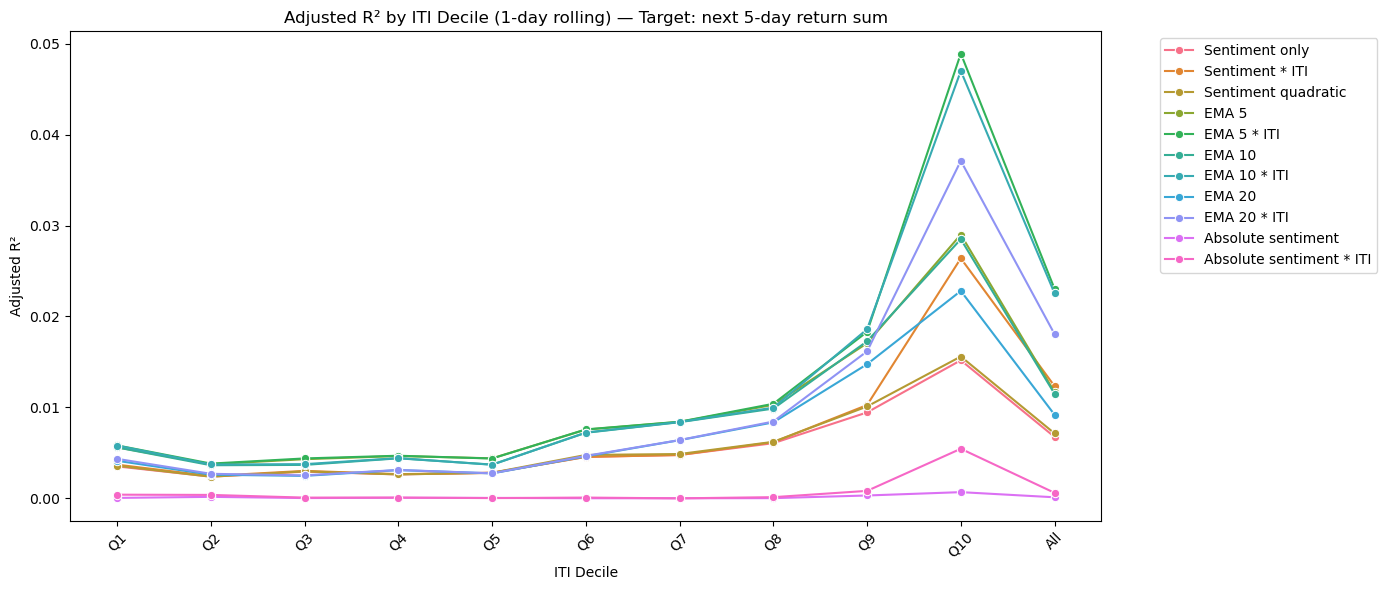

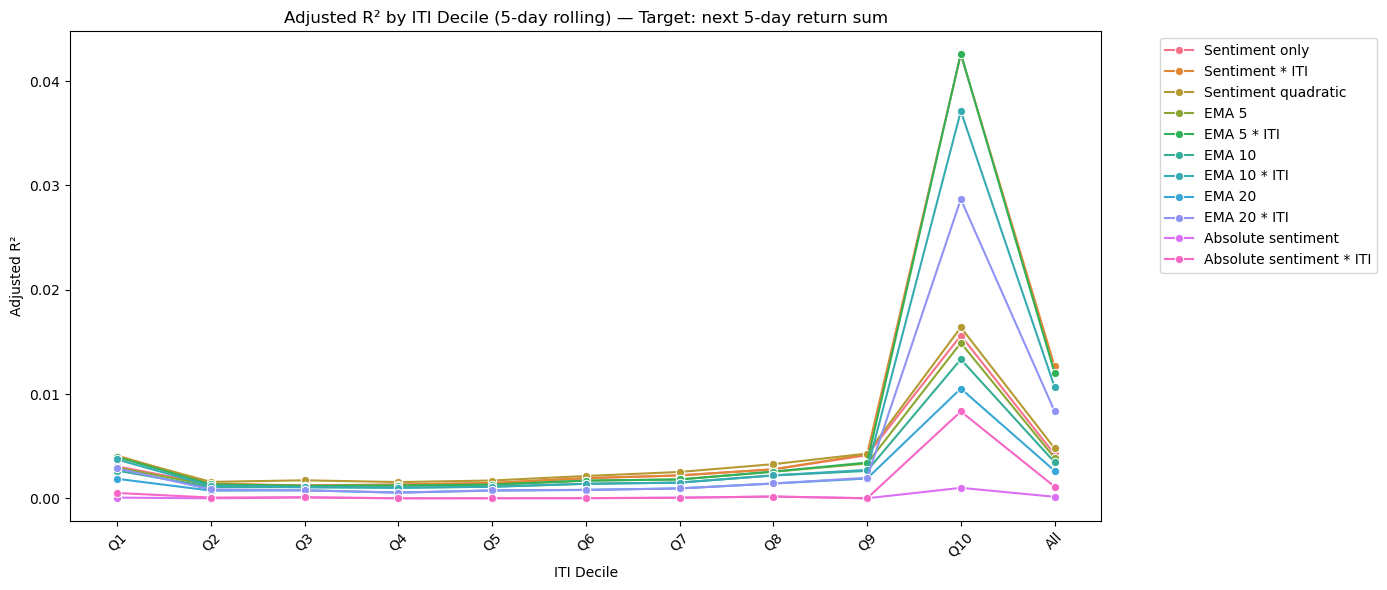

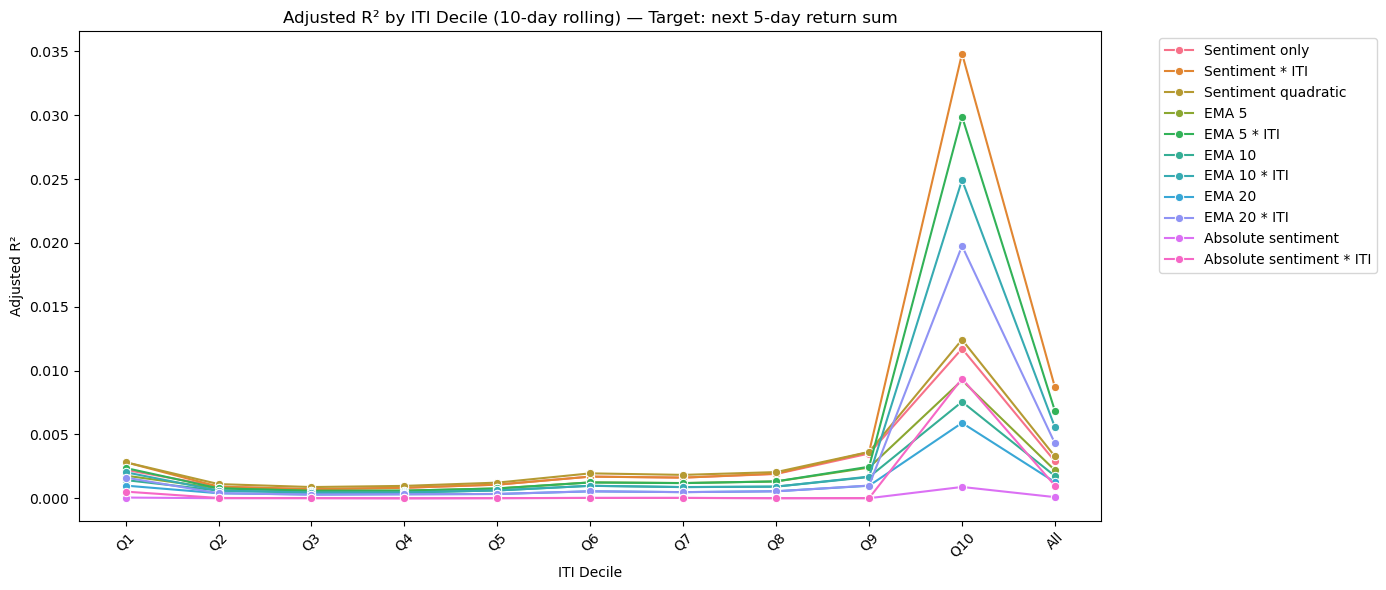

In [ ]:
# --- Imports ---
import polars as pl
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Assumptions:
# - df_analysis: Polars DataFrame with columns:
#   ['permno','date','close','ret', 'ITI', ('sentiment_score' or 'sentiment_mean'),
#    optionally: 'ema_sentiment_5_mean','ema_sentiment_10_mean','ema_sentiment_20_mean']
# ==============================

# --- Rolling window sizes to consider ---
window_sizes = [1, 5, 10]  # in days

# --- Dictionary of regression tests (target is fwd5_sum) ---
tests = {
    "Sentiment only":               "fwd5_sum ~ sentiment_mean",
    "Sentiment * ITI":              "fwd5_sum ~ sentiment_mean * ITI",
    "Sentiment quadratic":          "fwd5_sum ~ sentiment_mean + I(sentiment_mean**2)",
    "EMA 5":                        "fwd5_sum ~ ema_sentiment_5_mean",
    "EMA 5 * ITI":                  "fwd5_sum ~ ema_sentiment_5_mean * ITI",
    "EMA 10":                       "fwd5_sum ~ ema_sentiment_10_mean",
    "EMA 10 * ITI":                 "fwd5_sum ~ ema_sentiment_10_mean * ITI",
    "EMA 20":                       "fwd5_sum ~ ema_sentiment_20_mean",
    "EMA 20 * ITI":                 "fwd5_sum ~ ema_sentiment_20_mean * ITI",
    "Absolute sentiment":           "fwd5_sum ~ abs(sentiment_mean)",
    "Absolute sentiment * ITI":     "fwd5_sum ~ abs(sentiment_mean) * ITI",
}

# ------------------------------------------------------------

df_daily = df_analysis.sort(["permno", "date"])



def ema(df: pl.DataFrame, src: str, span: int, out: str) -> pl.DataFrame:
    if out in df.columns:
        return df
    alpha = 2.0 / (span + 1.0)
    return df.with_columns(
        pl.col(src).ewm_mean(alpha=alpha, adjust=False).over("permno").alias(out)
    )

df_daily = ema(df_daily, "sentiment_score", 5,  "ema_sentiment_5_mean")
df_daily = ema(df_daily, "sentiment_score", 10, "ema_sentiment_10_mean")
df_daily = ema(df_daily, "sentiment_score", 20, "ema_sentiment_20_mean")

# ------------------------------------------------------------
# Build forward 5-day sum target: ret_{t+1} + ... + ret_{t+5}
# ------------------------------------------------------------
fwd_cols = [pl.col("ret").shift(-i).over("permno").alias(f"_fwd_ret_{i}") for i in range(1, 6)]
df_daily = df_daily.with_columns(fwd_cols)
df_daily = df_daily.with_columns(
    pl.sum_horizontal([pl.col(f"_fwd_ret_{i}") for i in range(1, 6)]).alias("fwd5_sum")
).drop([f"_fwd_ret_{i}" for i in range(1, 6)])

# ------------------------------------------------------------
# Rolling means for *features* per permno (incl. ITI_mean_{w})
# ------------------------------------------------------------
def add_rolling_feature_means(df: pl.DataFrame, window: int) -> pl.DataFrame:
    df = df.sort(["permno", "date"])
    return df.with_columns([
        pl.col("sentiment_score").rolling_mean(window, min_samples=1).over("permno").alias(f"sent_score_{window}"),
        pl.col("ema_sentiment_5_mean").rolling_mean(window, min_samples=1).over("permno").alias(f"ema5_mean_{window}"),
        pl.col("ema_sentiment_10_mean").rolling_mean(window, min_samples=1).over("permno").alias(f"ema10_mean_{window}"),
        pl.col("ema_sentiment_20_mean").rolling_mean(window, min_samples=1).over("permno").alias(f"ema20_mean_{window}"),
        pl.col("ITI(13D)").rolling_mean(window, min_samples=1).over("permno").alias(f"ITI_mean_{window}"),
    ])


def remap_formula_for_window(formula: str, w: int) -> str:
    # Map LHS 'fwd5_sum' unchanged; remap RHS tokens only.
    repl = {
        "sentiment_mean":        f"sent_score_{w}",
        "sentiment_score":       f"sent_score_{w}",
        "ema_sentiment_5_mean":  f"ema5_mean_{w}",
        "ema_sentiment_10_mean": f"ema10_mean_{w}",
        "ema_sentiment_20_mean": f"ema20_mean_{w}",
        "ITI":                   f"ITI_mean_{w}",
    }
    lhs, rhs = formula.split("~")
    rhs_new = rhs
    for k, v in repl.items():
        rhs_new = rhs_new.replace(k, v)
    return f"{lhs.strip()} ~ {rhs_new.strip()}"

# ------------------------------------------------------------
# 4) Run regressions (All + by ITI decile) and collect adj R² (robust)
# ------------------------------------------------------------
def run_tests_collect(df_pl: pl.DataFrame, window_label: str, w: int):
    results = []
    df_pd = df_pl.to_pandas()

    # --- Full dataset regressions ---
    for name, formula in tests.items():
        f = remap_formula_for_window(formula, w)
        try:
            model = smf.ols(f, data=df_pd).fit()
            results.append({"window": window_label, "decile": "All", "test": name, "adj_r2": model.rsquared_adj})
        except Exception:
            results.append({"window": window_label, "decile": "All", "test": name, "adj_r2": None})

    # --- Deciles on ITI_mean_w (tie/NaN-robust qcut) ---
    iti_col = f"ITI_mean_{w}" if f"ITI_mean_{w}" in df_pd.columns else "ITI"

    # Clean decile variable
    iti_vals = df_pd[iti_col].replace([np.inf, -np.inf], np.nan)
    mask_good = iti_vals.notna()
    df_pd_dec = df_pd.loc[mask_good].copy()

    # Rank first to break ties; then qcut
    if df_pd_dec.shape[0] > 0:
        df_pd_dec["__rank__"] = df_pd_dec[iti_col].rank(method="first")
        try:
            df_pd_dec["ITI_decile"] = pd.qcut(df_pd_dec["__rank__"], 10, labels=[f"Q{i}" for i in range(1, 11)])
        except Exception:
            # fallback to fewer bins if too few unique values
            nbins = min(int(df_pd_dec["__rank__"].nunique()), 5)
            if nbins >= 2:
                df_pd_dec["ITI_decile"] = pd.qcut(df_pd_dec["__rank__"], nbins, labels=[f"B{i}" for i in range(1, nbins + 1)])
            else:
                # cannot form bins; return only "All"
                return results

        # Fit within each bin (skip tiny groups to avoid singular fits)
        for decile, df_dec in df_pd_dec.groupby("ITI_decile", observed=True):
            if len(df_dec) < 30:
                continue
            for name, formula in tests.items():
                f = remap_formula_for_window(formula, w)
                try:
                    model = smf.ols(f, data=df_dec).fit()
                    results.append({"window": window_label, "decile": str(decile), "test": name, "adj_r2": model.rsquared_adj})
                except Exception:
                    results.append({"window": window_label, "decile": str(decile), "test": name, "adj_r2": None})

    return results


all_results = []
for w in window_sizes:
    df_w = add_rolling_feature_means(df_daily, w)
    all_results.extend(run_tests_collect(df_w, f"{w}-day rolling", w))


df_results = pd.DataFrame(all_results)

# Drop invalid fits
df_results = df_results.dropna(subset=["adj_r2"])

# Order deciles;
std_deciles = [f"Q{i}" for i in range(1, 11)]
fallback_bins = [f"B{i}" for i in range(1, 6)]
decile_categories = [*std_deciles, *fallback_bins, "All"]
existing = [d for d in decile_categories if d in set(df_results["decile"].astype(str))]
df_results["decile"] = pd.Categorical(df_results["decile"].astype(str), categories=existing, ordered=True)

# Plot
for w in window_sizes:
    window_label = f"{w}-day rolling"
    dat = df_results[df_results["window"] == window_label]
    if dat.empty:
        continue
    plt.figure(figsize=(14, 6))
    sns.lineplot(
        data=dat,
        x="decile", y="adj_r2", hue="test", marker="o"
    )
    plt.title(f"Adjusted R² by ITI Decile ({window_label}) — Target: next 5-day return sum")
    plt.xlabel("ITI Decile")
    plt.ylabel("Adjusted R²")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()